In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 

from imblearn.over_sampling import SMOTE
from collections import Counter  

from sklearn.tree import DecisionTreeClassifier
import funciones

from feature_engine.discretisation import DecisionTreeDiscretiser

import pygad

import time

In [2]:
datos = pd.read_csv('/home/juan/proyectoTesis/datasets/creditcard.csv')

datos.shape

#Ver balanceo de la clase objetivo. Diabetes_012
porcentaje = 100*datos['Class'].value_counts()/len(datos)
print(porcentaje.astype(str) + '%')

Class
0       99.827251436938%
1    0.1727485630620034%
Name: count, dtype: object


In [3]:
#Discretizar caracteristicas por medio de arboles de decision
X = datos.drop("Class", axis=1)
y = datos["Class"]

columnas_disc = X.columns.to_list()

disc = DecisionTreeDiscretiser(bin_output="bin_number",
                                        cv=3,
                                        scoring="roc_auc",
                                        variables= columnas_disc, 
                                        regression=False)

disc.fit(X, y)

X_disc = disc.transform(X)


In [4]:
def fitness_mod(ga_instance, solution, solution_idx):
    # decodificar solucion 
    selected_features = []

    for i in range(len(solution)):
        
        if solution[i]==1:
            selected_features.append(columnas_disc[i])
    
    if not selected_features:
        return 0
        
    # Llamar a tasa_inconsistencia
    inconsistency_rate = funciones.tasa_inconsistencia(
        df=X_disc.join(y), 
        subconjunto_caracteristicas=selected_features, 
        clase='Class'
    )
    
    # Si inconsistency_rate es 0 (perfecto), el fitness sera maximo.
    fitness = 1.0 - inconsistency_rate
    
    return fitness

def fitness_mod_peso_cardinalidad(ga_instance, solution, solution_idx):
    # decodificar solucion 
    selected_features = []

    for i in range(len(solution)):
        
        if solution[i]==1:
            selected_features.append(columnas_disc[i])
    
    if not selected_features:
        return 0
        
    # Llamar a tasa_inconsistencia
    inconsistency_rate = funciones.tasa_inconsistencia(
        df=X_disc.join(y), 
        subconjunto_caracteristicas=selected_features, 
        clase='Class'
    )
    num_caracteristicas = np.sum(solution)
    penalizacion = 0.00001 * num_caracteristicas
    
    
    # Si inconsistency_rate es 0 (perfecto), el fitness sera maximo.
    fitness = 1.0 - inconsistency_rate - penalizacion
    
    return fitness

In [5]:
def callback_generation(ga_instance):
    current_time = time.time()

    duracion = current_time - ga_instance.last_execution_time

    best_solution, best_fitness, best_idx = ga_instance.best_solution()
    # Contamos el número de características (la suma de 1s en el cromosoma)
    num_caracteristicas = np.sum(best_solution)

    
    print(f"Generación : {ga_instance.generations_completed}")
    
    
    best_fitness = ga_instance.best_solution()[1]
    mejores_caracteristicas = []
    for i in range(len(best_solution)):
        if best_solution[i] == 1:
            mejores_caracteristicas.append(columnas_disc[i])
    print(f"Número de caracteristicas de la mejor solucion: {num_caracteristicas}")        
    print(f"Mejor Fitness : {best_fitness}")
    print("**************************************")
    print(f"Variables de la mejor solucion: {mejores_caracteristicas}")
    print("**************************************")
    print(f"Duración de la Generación : {duracion:.2f} segundos") 
    print("----------------")

    ga_instance.last_execution_time = current_time

In [6]:
#CReacion de poblacion (trataremos que el promedio de cardinalidad de la poblacion sea bajo, para explorar mas cromosomas con pocas caracteristicas).
num_features_per_chromosome = np.linspace(start=2, stop=14, num=30).astype(int)

num_features_per_chromosome
print(np.sum(num_features_per_chromosome / len(num_features_per_chromosome)))
np.random.shuffle(num_features_per_chromosome)
print(num_features_per_chromosome)

initial_population = []


# Bucle para crear cada cromosoma
for unos in num_features_per_chromosome:
    # Inicializacion de cromosomas (todos los valores igual a cero)
    chromosome = np.zeros(num_genes)
    
    # Elegir indices donde estaran los 1s 
    indices_to_set_one = np.random.choice(range(num_genes), size=unos, replace=False)
    
    # Ponemos los 1s en esas posiciones
    chromosome[indices_to_set_one] = 1
    
    # Añadimos el cromosoma terminado a nuestra población
    initial_population.append(chromosome)

initial_population = np.array(initial_population)

#initial_population



7.533333333333334
[14 13 10  6  7 11  4 10  3 12  5 13  2  2  9 11  3  9  5  8  7 11 12  6
  2  8  4  6  4  9]


NameError: name 'num_genes' is not defined

In [7]:
#Algoritmo genetico para la seleccion de variables.
num_genes = len(X_disc.columns)
sol_per_pop= 30
num_generations=20
ga_instance = pygad.GA(
    initial_population = initial_population,
    num_generations=num_generations,
    num_parents_mating=1, #numero de padres que seran seleccionados para reproducirse.
    parent_selection_type="tournament",
    K_tournament= 2,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=[0, 1],
    mutation_type="random",
    mutation_probability = 0.01,
    fitness_func=fitness_mod_peso_cardinalidad,
    save_solutions=True,
    on_generation=callback_generation,
    random_seed= 424
)


A 2D list is expected to the initial_population parameter but a (1-D) list found.
Traceback (most recent call last):
  File "/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/pygad/pygad.py", line 442, in __init__
    raise ValueError(f"A 2D list is expected to the initial_population parameter but a ({numpy.array(initial_population).ndim}-D) list found.")
ValueError: A 2D list is expected to the initial_population parameter but a (1-D) list found.


ValueError: A 2D list is expected to the initial_population parameter but a (1-D) list found.

In [ ]:
print("***********************Población inicial:**************************")
print(ga_instance.population)
print("*******************************************************************")

***********************Población inicial:**************************
[[1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
  0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.
  0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  1

In [ ]:
cardinalidad_cromosomas_poblacion_inicial = []
for cromosoma in ga_instance.population:
    num_caracteristicas= np.sum(cromosoma)
    cardinalidad_cromosomas_poblacion_inicial.append(num_caracteristicas)



promedio_cardinalidad = np.sum(cardinalidad_cromosomas_poblacion_inicial)/len(ga_instance.population[0])

print(f"El promedio de cardinalidad de la poblacion generada aleatoriamente es: {promedio_cardinalidad}")

El promedio de cardinalidad de la poblacion generada aleatoriamente es: 7.533333333333333


In [ ]:
#inicializar marca de tiempo
ga_instance.last_execution_time = time.time()

ga_instance.run()

Generación : 1
Número de caracteristicas de la mejor solucion: 11.0
Mejor Fitness : 0.9996512418234101
**************************************
Variables de la mejor solucion: ['V3', 'V4', 'V10', 'V11', 'V13', 'V17', 'V21', 'V22', 'V23', 'V25', 'V26']
**************************************
Duración de la Generación : 62.73 segundos
----------------
Generación : 2
Número de caracteristicas de la mejor solucion: 11.0
Mejor Fitness : 0.9996512418234101
**************************************
Variables de la mejor solucion: ['V3', 'V4', 'V10', 'V11', 'V13', 'V17', 'V21', 'V22', 'V23', 'V25', 'V26']
**************************************
Duración de la Generación : 55.66 segundos
----------------
Generación : 3
Número de caracteristicas de la mejor solucion: 8.0
Mejor Fitness : 0.9996566637758202
**************************************
Variables de la mejor solucion: ['V9', 'V10', 'V14', 'V15', 'V19', 'V23', 'V24', 'Amount']
**************************************
Duración de la Generación : 38.

In [ ]:
#Distribuciones de fitness de la ultima generacion

fitness_values = ga_instance.last_generation_fitness

fitness_values 

array([0.99972253, 0.99972253, 0.99972253, 0.99972253, 0.99972253,
       0.99972253, 0.99972253, 0.99972253, 0.99967986, 0.99971955,
       0.99972253, 0.99972658, 0.99972253, 0.99972253, 0.99972253,
       0.99972253, 0.99972253, 0.99969742, 0.99971955, 0.99972253,
       0.99972307, 0.99972253, 0.99972253, 0.99971146, 0.99972253,
       0.99971955, 0.99972253, 0.99972253, 0.99971604, 0.99972253])

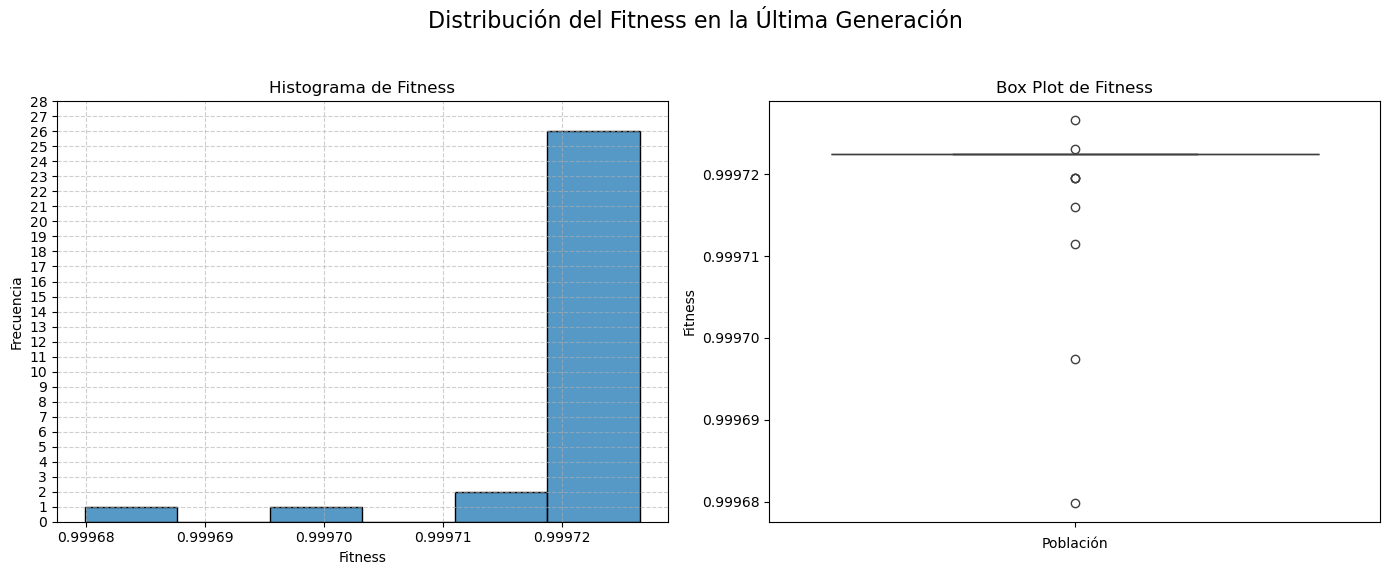

<Figure size 640x480 with 0 Axes>

In [ ]:

import numpy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribución del Fitness en la Última Generación', fontsize=16)

# Histograma
sns.histplot(fitness_values, ax=axes[0], kde=False)
axes[0].set_title('Histograma de Fitness')
axes[0].set_xlabel('Fitness')
y_max = axes[0].get_ylim()[1]
# Crear una lista de ticks de uno en uno, desde 0 hasta el máximo
y_ticks = numpy.arange(0, y_max + 1, 1)
axes[0].set_yticks(y_ticks)
# Establecer esos ticks en el eje Y del h
axes[0].set_ylabel('Frecuencia')
axes[0].ticklabel_format(style='plain', axis='x')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Box Plot
sns.boxplot(y=fitness_values, ax=axes[1])
axes[1].set_title('Box Plot de Fitness')
axes[1].set_xlabel('Población')
axes[1].set_ylabel('Fitness')


#guarda la figura.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig('fitness_distribution.png')

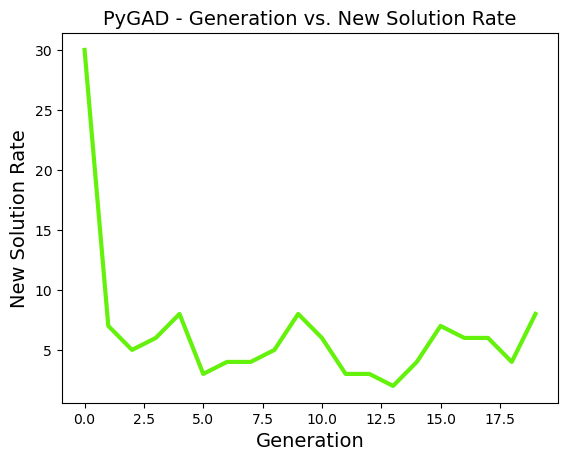

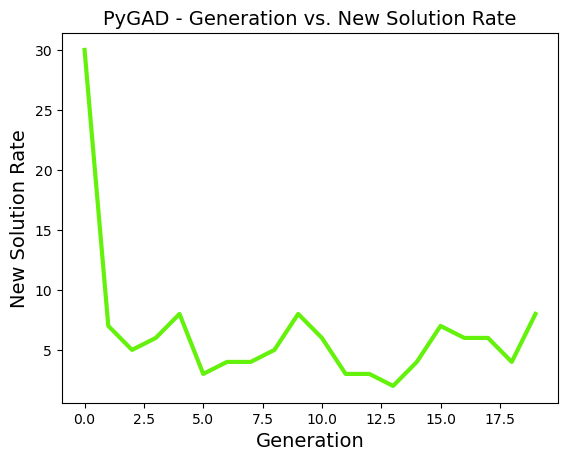

In [ ]:
ga_instance.plot_new_solution_rate()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print(f"Mejor Fitness Encontrado : {solution_fitness}\n")
print(f"Cromosoma de la Mejor Solución : \n{solution}\n")


Mejor Fitness Encontrado : 0.9997265763130821

Cromosoma de la Mejor Solución : 
[0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1.]

